In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from SDNet.model import SDNet
from MetaFusion.models.metafusion_net import FusionNet as FusionNetwork
from CDDFuse.net import Restormer_Encoder, Restormer_Decoder, BaseFeatureExtraction, DetailFeatureExtraction
from PIL import Image
from segment_anything.build_sam import build_siamese_sam
from segment_anything.dataloader import MedicalDataset
from segment_anything.utils import ContrasiveStructureLoss, LaplacianPyramid
from torchvision.transforms import transforms

In [2]:
sliceimg = 9
num_classes = 3
device = 'cpu'

In [3]:
test_CT = []
test_MRI = []

In [4]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/CT/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    gray_CT = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    test_CT.append(gray_CT)
    n += 1
    if not ret or n == sliceimg:
        break
print(n)

9


In [5]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/MR-T2/spatial (1).mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    gray_MRI = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    test_MRI.append(gray_MRI)
    n += 1
    if not ret or n == sliceimg:
        break
print(n)

9


In [6]:
test_CT = []
test_MRI = []
testIMG_path = 'testImg'
test_CT_path = os.path.join(testIMG_path, 'CT')
test_MRI_path = os.path.join(testIMG_path, 'MRI')
for i in os.listdir(test_CT_path):
    img_CT = cv2.imread(os.path.join(test_CT_path, i))
    img_CT = cv2.cvtColor(img_CT, cv2.COLOR_BGR2GRAY)
    test_CT.append(img_CT)
for i in os.listdir(test_MRI_path):
    img_MRI = cv2.imread(os.path.join(test_MRI_path, i))
    img_MRI = cv2.cvtColor(img_MRI, cv2.COLOR_BGR2GRAY)
    test_MRI.append(img_MRI)

## SSAM

In [7]:
PATH = 'model/SiameseSAM_epoch135.pth'
SiameseSAM = build_siamese_sam(num_classes=num_classes, checkpoint=PATH).to(device)
SiameseSAM.eval()
laplacian_pyramid = LaplacianPyramid(levels=4, device='cpu')

In [8]:
SSAM_output = []
for C, M, in zip(test_CT, test_MRI):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((1024, 1024))
            ])
    inputs = [transform(C), transform(M)]
    inputs = [i.to(device).unsqueeze(0) for i in inputs]
    laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
    inputs = [laplacian_CT[0], laplacian_MRI[0]]
    output = SiameseSAM(inputs)
    output[4] = laplacian_pyramid(output[4])
    img = output[4][0].squeeze(0).cpu().detach().numpy()
    SSAM_output.append(img)

/home/hansenfeng/anaconda3/envs/sam/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## SDNet

In [9]:
model_path = 'SDNet/model395'
net = SDNet()
net.eval()
net = net.to(device)
net.load_state_dict(torch.load(model_path))
transform = transforms.Compose([transforms.ToTensor()])

In [10]:
SDNet_output = []
for img1, img2 in zip(test_CT, test_MRI):  # CT-MRI Fusion
    img1 = transform(img1)
    img2 = transform(img2)
    img1 = img1.to(device).unsqueeze(0)
    img2 = img2.to(device).unsqueeze(0)
    fused_img, _, _ = net(img1, img2)
    fused_img = (fused_img - fused_img.min()) / (fused_img.max() - fused_img.min()) * 255.
    fused_img = fused_img.cpu().detach().numpy().squeeze()
    SDNet_output.append(fused_img)

## MetaFusion

In [11]:
checkpoint = 'MetaFusion/weight/model_weight.pth'
model = FusionNetwork(block_num=3, feature_out=False).to(device)
model.eval()
model.load_state_dict(torch.load(checkpoint), strict=True)

toPIL = transforms.ToPILImage()
img_transform = transforms.Compose([transforms.ToTensor()])

In [12]:
def bri_clr_loader(img1):
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    color = img1[:, :, 0:2]
    brightness = img1[:, :, 2]
    return brightness, color

def preprocess(test_CT, test_MRI):
    irimage, visimage_rgb = test_CT, test_MRI
    visimage_bri, visimage_clr = bri_clr_loader(visimage_rgb)
    visimage_bri = toPIL(visimage_bri)
    visimage_clr = toPIL(visimage_clr)
    irimage = img_transform(irimage)
    irimage = irimage.unsqueeze(0)
    visimage_rgb = img_transform(visimage_rgb)
    visimage_bri = img_transform(visimage_bri)
    visimage_clr = img_transform(visimage_clr)
    visimage_rgb = visimage_rgb.expand(3, -1, -1)
    visimage_rgb = visimage_rgb.unsqueeze(0)
    labels = 0
    return irimage, visimage_rgb, visimage_bri, visimage_clr, labels

In [13]:
Meta_output = []
for CT_meta, MRI_meta in zip(test_CT, test_MRI):
    irimage, visimage_rgb, visimage_bri, visimage_clr, image_name = preprocess(CT_meta, MRI_meta)

    ir_image = irimage.to(device)
    visimage_rgb = visimage_rgb.to(device)
    visimage_bri = visimage_bri.to(device)

    _, res_weight = model(torch.cat([ir_image, visimage_rgb], dim=1))
    fus_img = res_weight[:, 0, :, :] * ir_image + res_weight[:, 1, :, :] * visimage_bri

    # HSV2RGB
    bri = fus_img.detach().cpu().numpy() * 255
    bri = bri.reshape([fus_img.size()[2], fus_img.size()[3]])
    bri = np.where(bri < 0, 0, bri)
    bri = np.where(bri > 255, 255, bri)
    im1 = Image.fromarray(bri.astype(np.uint8))

    clr = visimage_clr.numpy().squeeze().transpose(1, 2, 0) * 255
    clr = np.concatenate((clr, bri.reshape(fus_img.size()[2], fus_img.size()[3], 1)), axis=2)

    clr[:, :, 2] = im1
    clr = cv2.cvtColor(clr.astype(np.uint8), cv2.COLOR_HSV2RGB)
    Meta_output.append(clr)

## CDDFuse

In [26]:
ckpt_path = r"CDDFuse/models/CDDFuse_MIF.pth"
model_name=ckpt_path.split('/')[-1].split('.')[0]

Encoder = nn.DataParallel(Restormer_Encoder()).to(device)
Decoder = nn.DataParallel(Restormer_Decoder()).to(device)
BaseFuseLayer = nn.DataParallel(BaseFeatureExtraction(dim=64, num_heads=8)).to(device)
DetailFuseLayer = nn.DataParallel(DetailFeatureExtraction(num_layers=1)).to(device)

Encoder.load_state_dict(torch.load(ckpt_path)['DIDF_Encoder'])
Decoder.load_state_dict(torch.load(ckpt_path)['DIDF_Decoder'])
BaseFuseLayer.load_state_dict(torch.load(ckpt_path)['BaseFuseLayer'])
DetailFuseLayer.load_state_dict(torch.load(ckpt_path)['DetailFuseLayer'])
Encoder.eval()
Decoder.eval()
BaseFuseLayer.eval()
DetailFuseLayer.eval()
transform = transforms.Compose([transforms.ToTensor()])

In [27]:
CDDFuse_output = []
with torch.no_grad():
    for CT_cddf, MRI_cddf in zip(test_CT, test_MRI):
        data_IR = transform(CT_cddf).unsqueeze(0)
        data_VIS = transform(MRI_cddf).unsqueeze(0)
        data_IR,data_VIS = torch.FloatTensor(data_IR),torch.FloatTensor(data_VIS)
        data_VIS, data_IR = data_VIS.to(device), data_IR.to(device)

        feature_V_B, feature_V_D, feature_V = Encoder(data_VIS)
        feature_I_B, feature_I_D, feature_I = Encoder(data_IR)
        feature_F_B = BaseFuseLayer(feature_V_B + feature_I_B)
        feature_F_D = DetailFuseLayer(feature_V_D + feature_I_D)

        data_Fuse, _ = Decoder(None, feature_F_B, feature_F_D)
        data_Fuse=(data_Fuse-torch.min(data_Fuse))/(torch.max(data_Fuse)-torch.min(data_Fuse))
        fi = np.squeeze((data_Fuse * 255).cpu().numpy())
        CDDFuse_output.append(fi)

## Plot

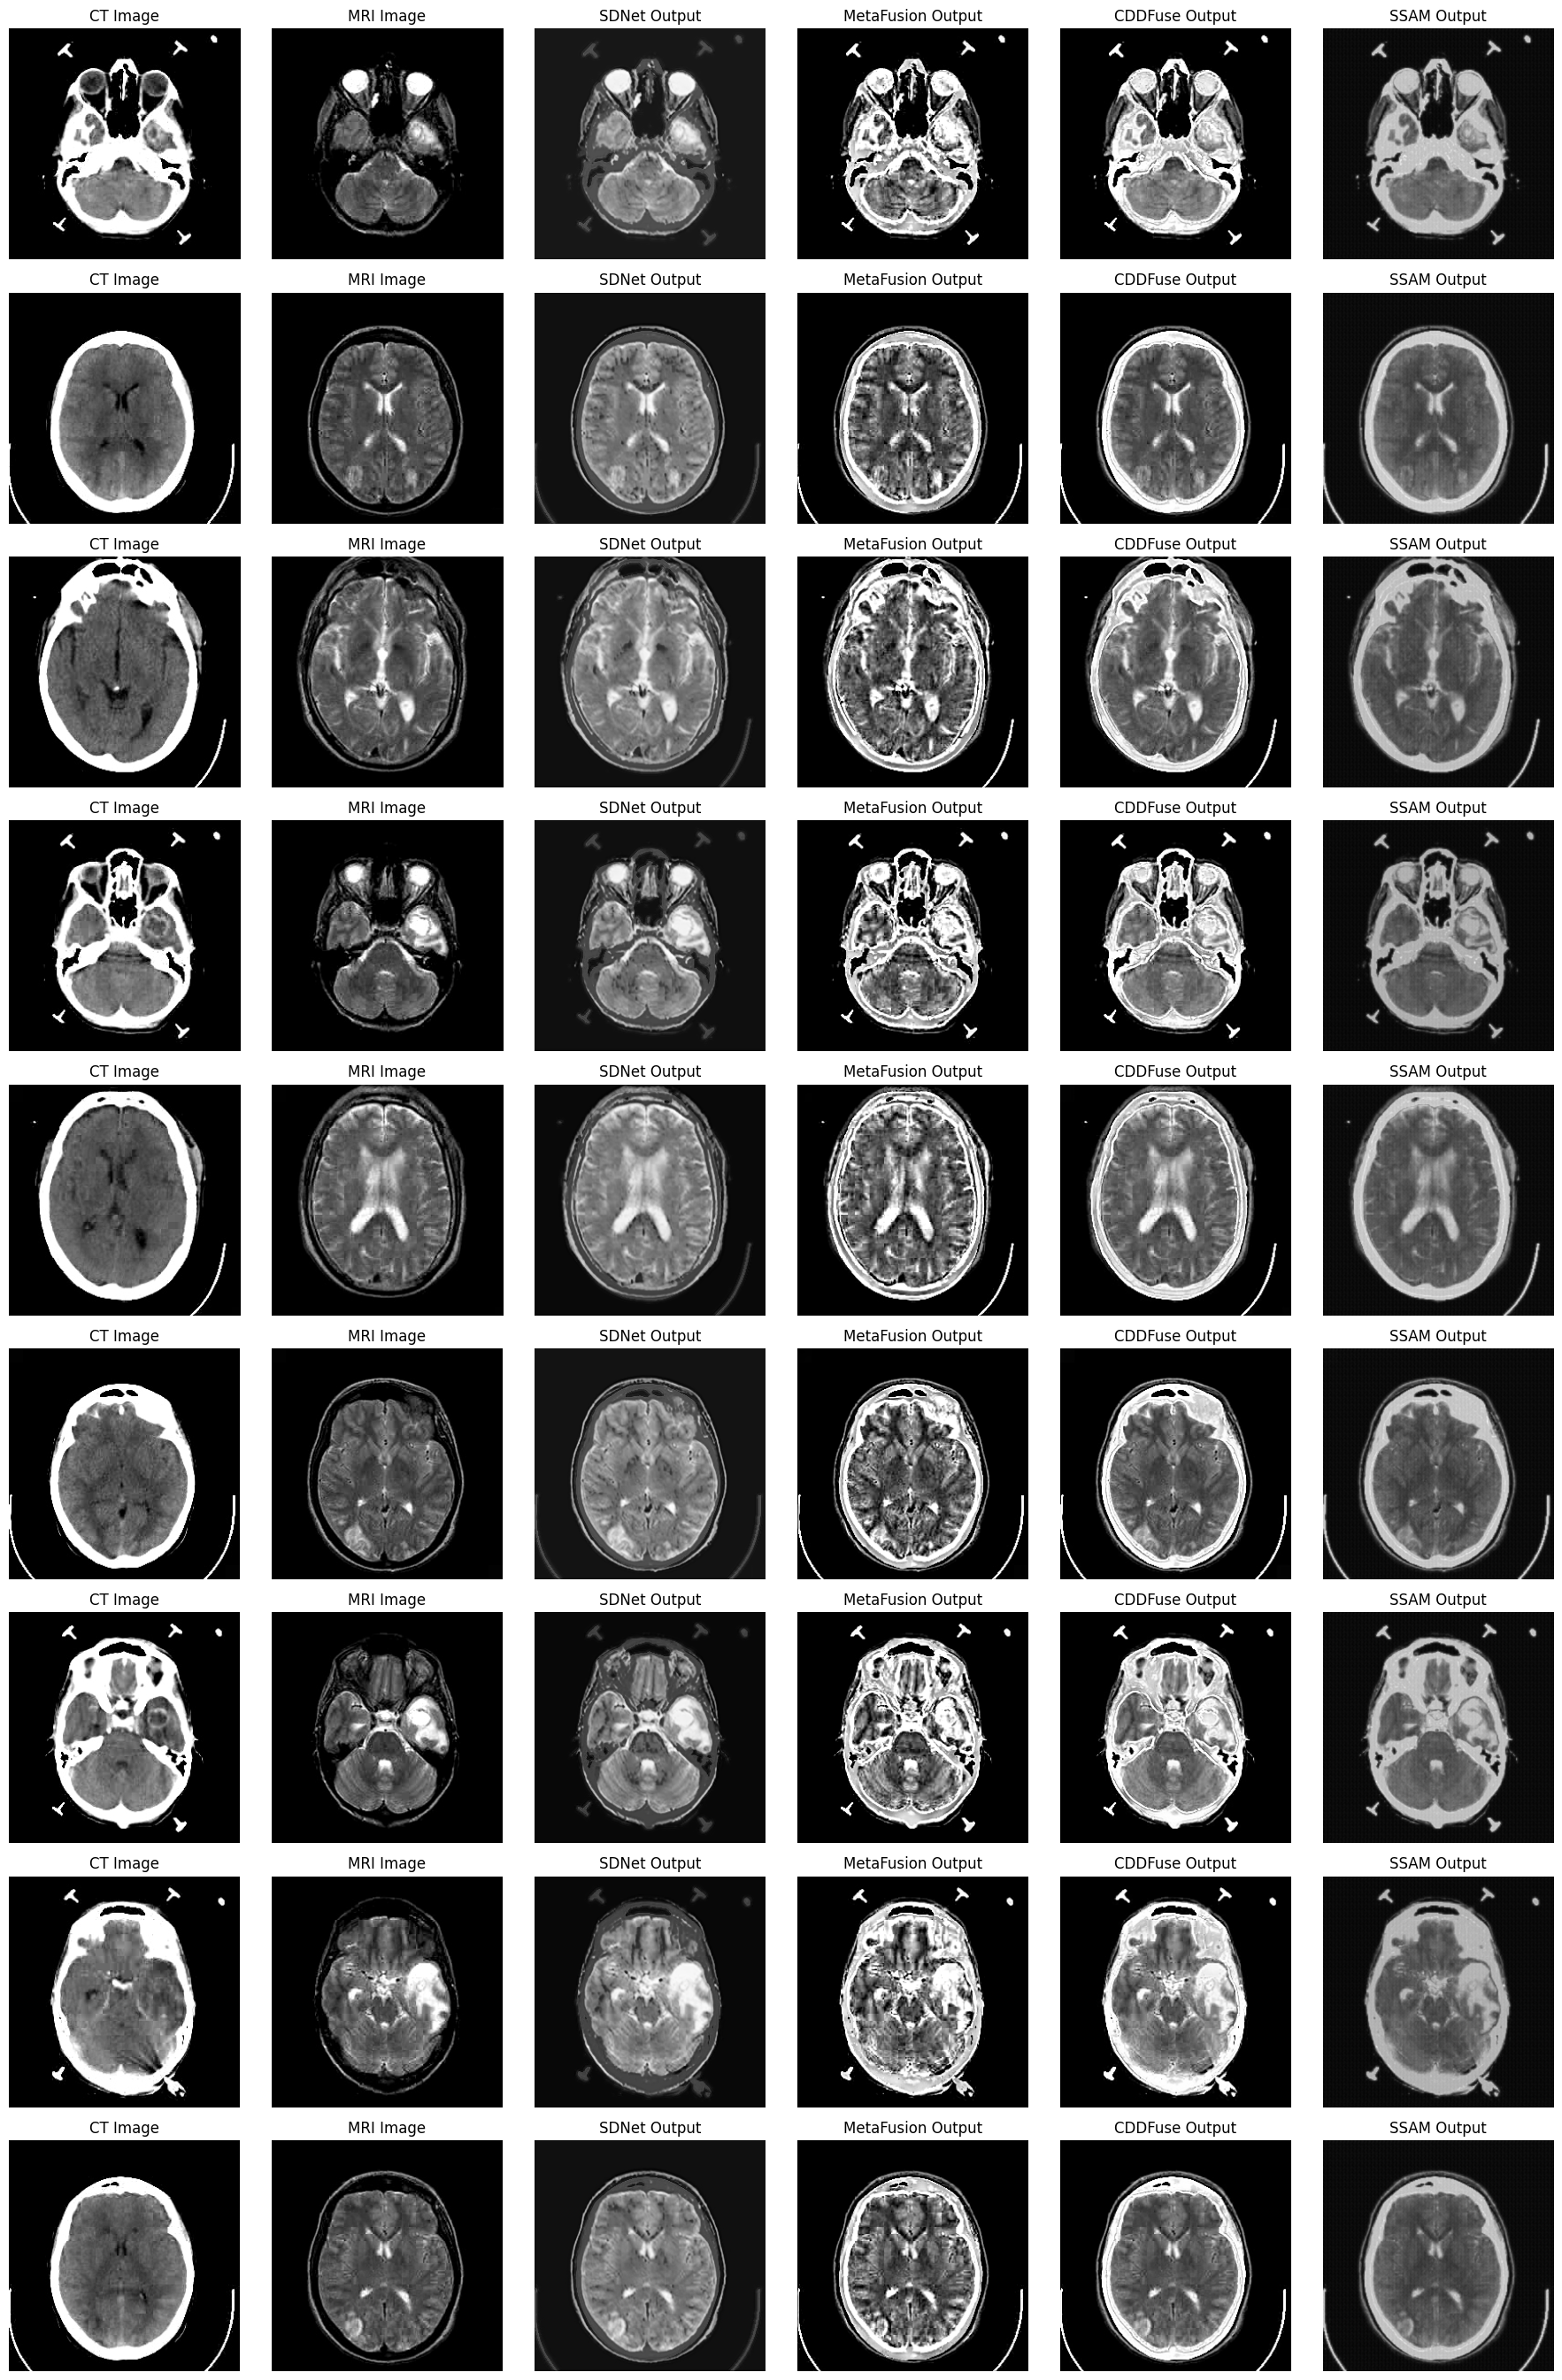

In [28]:
# 示例数据生成函数
def generate_image(shape=(128, 128)):
    return np.random.rand(*shape)

# 假设你有9个病例的原始CT和MRI影像以及四个模型的输出
num_slices = 9
ct_images = [generate_image() for _ in range(num_slices)]
mri_images = [generate_image() for _ in range(num_slices)]
model1_outputs = [generate_image() for _ in range(num_slices)]
model2_outputs = [generate_image() for _ in range(num_slices)]
model3_outputs = [generate_image() for _ in range(num_slices)]
model4_outputs = [generate_image() for _ in range(num_slices)]

# 创建一个3x5的网格
fig, axes = plt.subplots(num_slices, 6, figsize=(18, num_slices * 3))

# 绘制图像
for i in range(num_slices):
    # 绘制CT图像
    axes[i, 0].imshow(test_CT[i], cmap='gray')
    axes[i, 0].set_title('CT Image')
    axes[i, 0].axis('off')

    # 绘制MRI图像
    axes[i, 1].imshow(test_MRI[i], cmap='gray')
    axes[i, 1].set_title('MRI Image')
    axes[i, 1].axis('off')

    # 绘制模型1的输出
    axes[i, 2].imshow(SDNet_output[i], cmap='gray')
    axes[i, 2].set_title('SDNet Output')
    axes[i, 2].axis('off')

    # 绘制模型2的输出
    axes[i, 3].imshow(Meta_output[i], cmap='gray')
    axes[i, 3].set_title('MetaFusion Output')
    axes[i, 3].axis('off')

    # 绘制模型3的输出
    axes[i, 4].imshow(CDDFuse_output[i], cmap='gray')
    axes[i, 4].set_title('CDDFuse Output')
    axes[i, 4].axis('off')

    # 绘制模型4的输出
    axes[i, 5].imshow(SSAM_output[i], cmap='gray')
    axes[i, 5].set_title('SSAM Output')
    axes[i, 5].axis('off')

# 调整布局
plt.tight_layout()
plt.show()